# Categorical Predictors (ANOVA family)

In the [previous tutorial](./01_lm.ipynb) we met the `lm()` class for estimating univariate and multiple regression models. Here we'll build upon this by demonstrating how you can work with models that have *categorical* or *factor* predictors. All models include the following methods to make it easy to work with categorical predictors which we'll explore in this tutorial:

| Method | Description |
|--------|-------------|
| [`.set_factors()`](../api/models/lm.md#pymer4.models.base.model.set_factors) | Set a variable as a factor with alphabetaically sorted levels by default, or specify the exact level ordering; this changes the data-type to categorical/enum |
| [`.unset_factors()`](../api/models/lm.md#pymer4.models.base.model.unset_factors) | Unset all factor variables to their original datatype |
| [`.show_factors()`](../api/models/lm.md#pymer4.models.base.model.show_factors) | Show any set factors |
| [`.set_contrasts()`](../api/models/lm.md#pymer4.models.base.model.set_contrasts) | Encode factor levels using one of the supported coding schemes (`contr.treatment` by default) or a custom one using numeric codes that sum-to-zero |
| [`.show_contrasts()`](../api/models/lm.md#pymer4.models.base.model.show_contrasts) | Show any set contrasts |
| [`.anova()`](../api/models/lm.md#pymer4.models.base.model.anova) | Calculate a Type-III ANOVA table using `joint_tests()` in R |
| [`.summary_anova()`](../api/models/lm.md#pymer4.models.base.model.summary_anova) | Get a nicely formatted table containing `.result_anova` |
| [`.emmeans()`](../api/models/lm.md#pymer4.models.base.model.emmeans) | Compute marginal means/contrasts at specific factor levels |

## Basics

In the previous tutorial we estimated a model with a categorical predictor $cyl$

In [23]:
from pymer4.models import lm
from pymer4 import load_dataset
import numpy as np
from polars import col

mtcars = load_dataset('mtcars').select('mpg', 'wt', 'cyl')
model = lm('mpg ~ wt * cyl', data=mtcars)

We specified our factor variable and transformed a continuous variable

In [24]:
model.set_factors({'cyl': ['4', '6', '8']})
model.set_transforms({'wt': 'center'})

We saw that factor variables use *treatment contrasts* (dummy-coding) by default just like R. This means each parameter represents the difference between the first level and the nth level. 

For $cyl$, that would be $6-4$ and $8-4$ as $4$ is the first level of $cyl$ based on the order we provided to `.set_factors()`. 

In [25]:
model.show_contrasts()

{'cyl': 'contr.treatment'}


Using `.set_*` methods changes the underlying `.data` attribute of a model while the coresponding `.unset_*` methods undo those changes

In [26]:
model.data.head()

mpg,wt,cyl,wt_orig
f64,f64,enum,f64
21.0,-0.59725,"""6""",2.62
21.0,-0.34225,"""6""",2.875
22.8,-0.89725,"""4""",2.32
21.4,-0.00225,"""6""",3.215
18.7,0.22275,"""8""",3.44


In [6]:
# wt has been replaced by its original value previously
# stored in wt_orig
model.unset_transforms()
model.data.head()

mpg,wt,cyl
f64,f64,i64
21.0,2.62,6
21.0,2.875,6
22.8,2.32,4
21.4,3.215,6
18.7,3.44,8


In [27]:
# cyl is now back to an integer type
model.unset_factors()
model.data.head()

mpg,wt,cyl,wt_orig
f64,f64,i64,f64
21.0,-0.59725,6,2.62
21.0,-0.34225,6,2.875
22.8,-0.89725,4,2.32
21.4,-0.00225,6,3.215
18.7,0.22275,8,3.44


For factor variables there are several ways to work with `.set_contrasts()`.  
The first option is to use any of the default contrasts supported by R

In [28]:
# Mean-center weight again
model.set_transforms({'wt': 'center'})

model.set_factors({'cyl': ['4', '6', '8']})
model.set_contrasts({'cyl': 'contr.sum'})

model.show_contrasts()

{'cyl': 'contr.sum'}


Alternatively we can test a *specific* hypothesis by using a custom contrast across factor levels (numeric values that add up to 0). This is specified based on the order of levels set when using `.set_factors()`, or alphabetically by default.

If we inspect the data we can see that there seems to be an approximately linear trend across levels of $cyl$


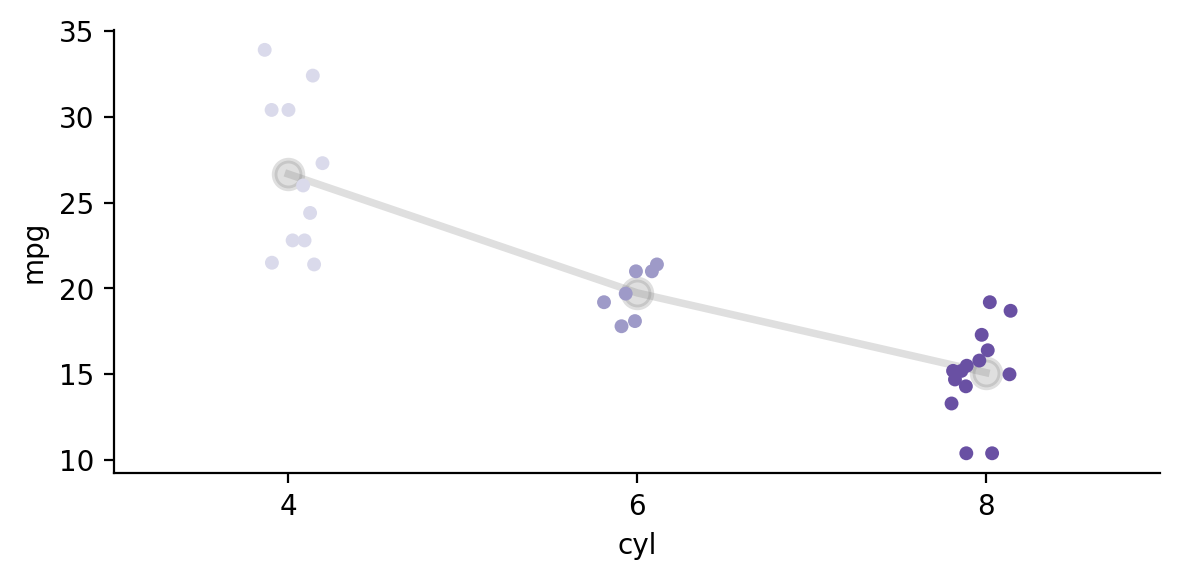

In [29]:
import seaborn as sns

grid = sns.FacetGrid(data=model.data, palette='Purples', aspect=2)

grid.map(sns.pointplot, 'cyl', 'mpg', color='gray', order=['4','6','8'], alpha=.25, errorbar=None, markersize=10)

grid.map_dataframe(sns.stripplot, 'cyl', 'mpg', order=['4','6','8'], hue='cyl', palette='Purples', legend=True);

We can test this by specifying a linear contrast across levels of `cyl` such that 4 < 6 < 8. 
The `normalize` argument simply scales our contrasts for us to match the polynomial used in R:

Now $cyl1$ below reflects *this specific* comparison: a linear trend across levels  
$cyl2$ represents an automatically computed orthogonal comparison, in this case a *quadratic* trend across $cyl$ levels. 

In [30]:
model.set_contrasts({'cyl':[-1, 0, 1]}, normalize=True)
model.fit()
model.params

term,estimate
str,f64
"""(Intercept)""",19.22742
"""wt""",-3.539856
"""cyl1""",-3.244839
"""cyl2""",-0.290422
"""wt:cyl1""",2.442762
"""wt:cyl2""",-0.9305


We can inspect the `.design_matrix` after fitting the model to see how our contrast was converted for R and how the second orthogonal contrast was automatically calculated. The code below just grabs and renames the unique rows to make the display easier to see. 

The first column is each level of $cyl$.  
The second column is our linear contrast `[-1, 0, 1]` converted to R's format of [contrast codes](https://www.uvm.edu/~statdhtx/StatPages/R/ContrastsInRShafer.pdf).  
The third column is the orthogonal contrast auto-calculated for us, which in this case is a *quadratic* trend

In [10]:

(
    model.design_matrix
    .select('cyl1', 'cyl2')
    .unique(maintain_order=True)
    .with_columns(model.data['cyl'].unique(maintain_order=True))
    .sort('cyl')
    .select('cyl', 'cyl1', 'cyl2')
    .rename({'cyl': 'level', 'cyl1': 'contrast1', 'cyl2': 'contrast2'})
)

level,contrast1,contrast2
enum,f64,f64
"""4""",-0.707107,0.408248
"""6""",0.0,-0.816497
"""8""",0.707107,0.408248


Our custom normalized linear contrast is equivalent to using the default `contr.poly` scheme, which models differences across factor levels as orthogonal polynomials.

Notice that while the parameter names have changes, the estimates are the same as above:

In [39]:
model.set_contrasts({'cyl': 'contr.poly'})
model.fit()
model.params

term,estimate
str,f64
"""(Intercept)""",19.22742
"""wt""",-3.539856
"""cyl.L""",-3.244839
"""cyl.Q""",-0.290422
"""wt:cyl.L""",2.442762
"""wt:cyl.Q""",-0.9305


Using `.set_contrasts()` has a direct influence on what a model's *parameter estimates* represent. This will influence the output of what you see with `.summary()`, `.params`, and `.result_fit`

This is one way to work with categorical predictors, sometimes called "planned-comparisons". Later in this tutorial we'll see an alternative, more general approach using *marginal effects estimation.*

## Common statistical tests are regression

A variety of common statistical tests that involve comparisons between 2 or more groups, are just linear regression models with categorical predictors:

| Often called | GLM predictor(s) $X$ | Example |
|-------------|---------|-------------|
| T-test | 1 two-level categorical | `y ~ group` <br/> e.g. group levels: <br/> `['a', 'b']` |
| One-way ANOVA | 1 three+ level categorical | `y ~ group` <br/> e.g. group levels: <br/> `['a', 'b', 'c']` |
| ANCOVA | 1 three+ level categorical & 1+ continuous | `y ~ group + covariate` |
| Moderation | 1 three+ level categorical & 1+ continuous & interaction | `y ~ group * covariate` |
| Factorial ANOVA | 2 or more two+ level categoricals | `y ~ group * category * color` |


## 2-levels (t-test)

Let's start with a simple example using a categorical variable $Student$ with 2 levels to compare mean differences in $Balance$

$$ Balance \sim \beta_0 + \beta_1 * Student$$


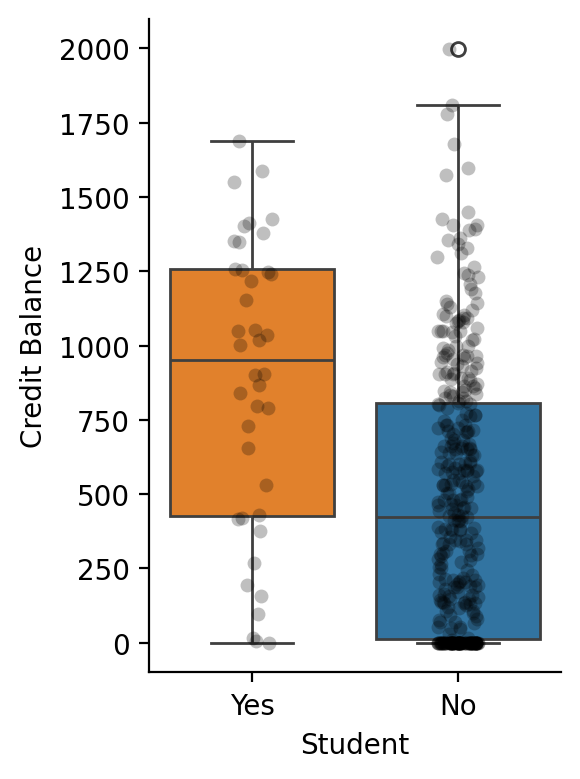

In [1]:
df = load_dataset("credit")

grid = sns.catplot(
    x="Student",
    y="Balance",
    kind="box",
    hue="Student",
    order=["Yes", "No"],
    aspect=0.75,
    height=4,
    data=df.to_pandas(),
)
grid.map(
    sns.stripplot, "Student", "Balance", color="black", alpha=0.25, order=["Yes", "No"]
).set_ylabels('Credit Balance');

After creating the model, we can use `.set_factors()` treat $Student$ as a categorical variable. Its levels will be alphabetical by default

In [2]:
model = lm('Balance ~ Student', data=df)

model.set_factors('Student')

model.show_factors()

{'Student': ['No', 'Yes']}


This means that our parameter estimate $\beta_1$ will reflect $Student_{Yes} - Student_{No}$

In [4]:
model.fit(summary=True)

GT(_tbl_data=shape: (2, 9)
┌─────────────┬────────────┬───────────┬────────────┬───┬───────────┬─────┬─────────┬───────┐
│ term        ┆ estimate   ┆ std_error ┆ conf_low   ┆ … ┆ t_stat    ┆ df  ┆ p_value ┆ stars │
│ ---         ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---       ┆ --- ┆ ---     ┆ ---   │
│ str         ┆ f64        ┆ f64       ┆ f64        ┆   ┆ f64       ┆ i64 ┆ str     ┆ str   │
╞═════════════╪════════════╪═══════════╪════════════╪═══╪═══════════╪═════╪═════════╪═══════╡
│ (Intercept) ┆ 480.369444 ┆ 23.43385  ┆ 434.299848 ┆ … ┆ 20.498956 ┆ 398 ┆ <.001   ┆ ***   │
│ StudentYes  ┆ 396.455556 ┆ 74.104339 ┆ 250.770699 ┆ … ┆ 5.349964  ┆ 398 ┆ <.001   ┆ ***   │
└─────────────┴────────────┴───────────┴────────────┴───┴───────────┴─────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x17e4b7530>, _boxhead=Boxhead([ColInfo(var='term', type=<ColInfoTypeEnum.stub: 2>, column_label='term', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x30eee7140>, _spanners=Spanners([]), _heading=Heading(title='Formula: lm(Balance~Student)', subtitle=Md(text='Number of observations: *400*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            R-squared: *0.0671*  \n            R-squared-adj: *0.0647*  \n            *F(1, 398) = 28.622, p = <.001*  \n            Log-likelihood: *-3005*  \n            AIC: *6016* | BIC: *6028*  \n            Residual error: *444.626*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x17f8c5370>, _formats=[<great_tables._gt_data.FormatInfo object at 0x17f9b61e0>, <great_tables._gt_data.FormatInfo object at 0x30c030b60>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category

The t-test on the $\beta_1$ is equivalent to a two-sample t-test:

In [5]:
# compare to scipy
from scipy.stats import ttest_ind

student = df.filter(col('Student') == 'Yes').select('Balance')
non_student = df.filter(col('Student') == 'No').select('Balance')

results = ttest_ind(student, non_student)
print(f"Scipy T-test:\ndiff = {student.mean().item() - non_student.mean().item():.3f} t= {results.statistic[0]:.2f} p = {results.pvalue[0]:.3f}")

Scipy T-test:
diff = 396.456 t= 5.35 p = 0.000


## 3-levels (one-way ANOVA)

With more than 2 levels of a factor you may want to calculate an F-table, i.e. an ANOVA

In [11]:
penguins = load_dataset('penguins')

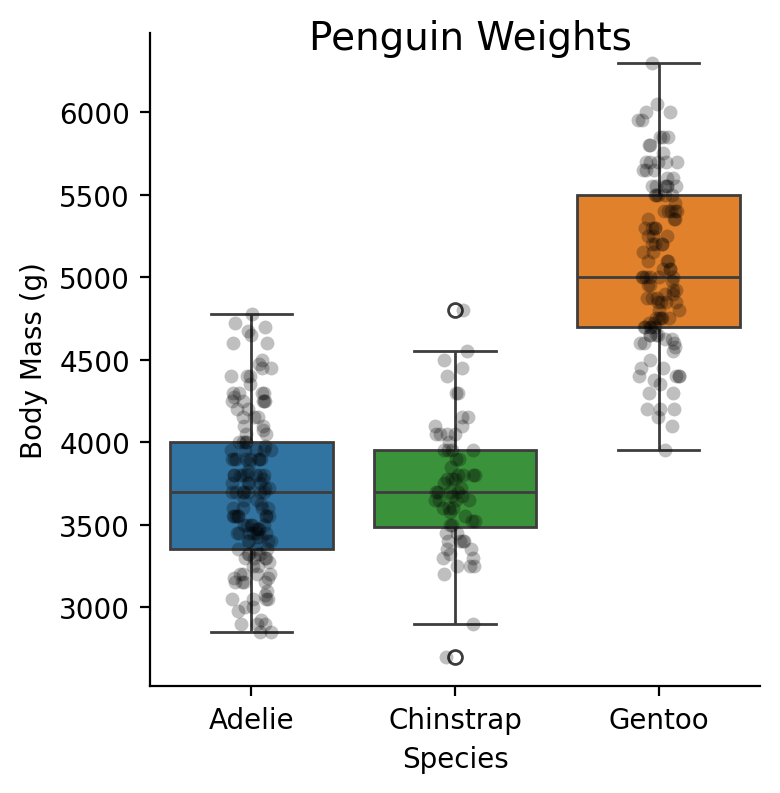

In [7]:
grid = sns.catplot(
    x="species",
    y="body_mass_g",
    kind="box",
    hue="species",
    order=["Adelie", "Chinstrap", "Gentoo"],
    aspect=1,
    height=4,
    data=penguins.to_pandas(),
)
grid.map(
    sns.stripplot,
    "species",
    "body_mass_g",
    color="black",
    alpha=0.25,
    order=["Adelie", "Chinstrap", "Gentoo"],
).set_axis_labels("Species", "Body Mass (g)").figure.suptitle("Penguin Weights", x=.6, fontsize=14);

Let's say we're interested in the main-effect of $Species$ on $Body Mass$ 

We can use just `.set_factors()` and call the `.anova()` method

In [32]:
model = lm('body_mass_g ~ species', data=penguins)
model.set_factors('species')
model.anova(summary=True)

GT(_tbl_data=shape: (1, 6)
┌────────────┬─────┬───────┬─────────┬─────────┬───────┐
│ model term ┆ df1 ┆ df2   ┆ F_ratio ┆ p_value ┆ stars │
│ ---        ┆ --- ┆ ---   ┆ ---     ┆ ---     ┆ ---   │
│ str        ┆ f64 ┆ f64   ┆ f64     ┆ str     ┆ str   │
╞════════════╪═════╪═══════╪═════════╪═════════╪═══════╡
│ species    ┆ 2.0 ┆ 339.0 ┆ 343.626 ┆ <.001   ┆ ***   │
└────────────┴─────┴───────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x3290ad190>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x337844920>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x337842120>, _formats=[<great_tables._gt_data.FormatInfo object at 0x335f13650>, <great_tables._gt_data.FormatInfo object at 0x328ed0140>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInf

Using `.anova()` is the most convenient way to get omnibus tests on categorical variables (i.e. *main effects*) especially with more complicated designs. By default it will completely ignore any contrasts you have set (or default contrasts) and use the appropriate ones in the face of both balanced and unbalanced group designs (i.e. orthogonal type-III SS) via [`emmeans::joint_tests`](https://www.rdocumentation.org/packages/emmeans/versions/1.3.5.1/topics/joint_tests). 

This makes it easy to inspect a summary of the hypothesis tests setup by your parameterization without worrying about the correct ANOVA coding-schemes for categorical predictors. Just set your factors with `.set_factors()` and call `.anova()` 

In [14]:
# Unchanged by ANOVA and determines what we see in .summary()
model.show_contrasts()

{'species': 'contr.treatment'}


In [ ]:
# Default treatment contrast with Adelie
# as the reference because alphabetical order
model.params

term,estimate
str,f64
"""(Intercept)""",3700.662252
"""speciesChinstrap""",32.425984
"""speciesGentoo""",1375.354009


## Marginal Effects Estimation

Previously we saw how using `.set_contrasts()` allows us to *parameterize* our model so we can test specific hypotheses about the levels of a factor variable (e.g. treatment-coding, linear-trend, etc). However, to test a different hypothesis requires re-fitting a new model with new contrasts.

An alternative approach is to compare *predictions* from a fitted model using predictors set/fixed to particular values. Aggregating and comparing these model-predictions is known as [*marginal effects estimation*](https://www.the100.ci/2022/05/27/%e2%9c%a8-unleash-your-inner-stats-sparkle-%e2%9c%a8-with-this-very-non-technical-introduction-to-marginal-effects/). It's an incredibly powerful general-purpose approach that encompasses traditional techniques like "post-hoc tests" as well as modern approaches like counter-factual estimations. It also makes it easier to reason about more complicated generalized models with interactions, without [struggling to potentially mis-interpret parameter estimates alone](https://datacolada.org/57).

In `pymer4` you can compare marginal estimates of each factor levels using `.emmeans()`, with the order based on how we used `.set_factors()` and generate arbitrary predictions and comparisons using `.empredict()`

Using a factor variable as the first argument to `.emmeans()` provides marginal estimates at each level of the factor while any other model parameters are held at their mean:

In [33]:
model.emmeans('species')

species,emmean,SE,df,lower_CL,upper_CL
cat,f64,f64,f64,f64,f64
"""Adelie""",3700.662252,37.619354,339.0,3610.391084,3790.93342
"""Chinstrap""",3733.088235,56.059001,339.0,3598.569406,3867.607064
"""Gentoo""",5076.01626,41.681876,339.0,4975.996691,5176.035829


By using the `contrasts` argument, you can setup various comparisons of interest with multiple-comparisons correction. Using the `'pairwise'` will perform all possible pairwise comparisons. In this case we have only 1 predictor with 3 levels:

In [34]:
model.emmeans('species', contrasts='pairwise', p_adjust='sidak')

contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""Adelie - Chinstrap""",-32.425984,67.511684,339.0,-194.426598,129.574631,-0.480302,0.949888
"""Adelie - Gentoo""",-1375.354009,56.147971,339.0,-1510.086328,-1240.621689,-24.495169,0.0
"""Chinstrap - Gentoo""",-1342.928025,69.856928,339.0,-1510.556273,-1175.299777,-19.223978,0.0


We can also can test a specific comparison using numeric codes in the same order as factor levels

In [35]:
model.emmeans('species', contrasts={'adelie_vs_others': [1, -0.5, -0.5]})

contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""adelie_vs_others""",-703.889996,51.33433,339.0,-804.863928,-602.916064,-13.711877,2.3870e-34


Compare this to the approach we used before with `.set_contrasts()`, which allowed us to *parameterize* a model to test specific comparisons, thus changing what *parameter estimates represent*.  
Using `.emmeans()` compares model *predictions*, making it a more generally usefully approach that allows you to ask many questions from a single estimated model.

Parameterizing our model the same way as our marginal estimation above matches the estimated value:

In [ ]:
# With auto-solve for other orthogonal contrasts
# speceis1 represents the same comparison as above
model.set_contrasts({'species': [1, -.5, -.5]})
model.fit()
model.params

term,estimate
str,f64
"""(Intercept)""",4169.922249
"""species1""",-703.889996
"""species2""",949.593513


## Multiple predictors (factorial ANOVA)

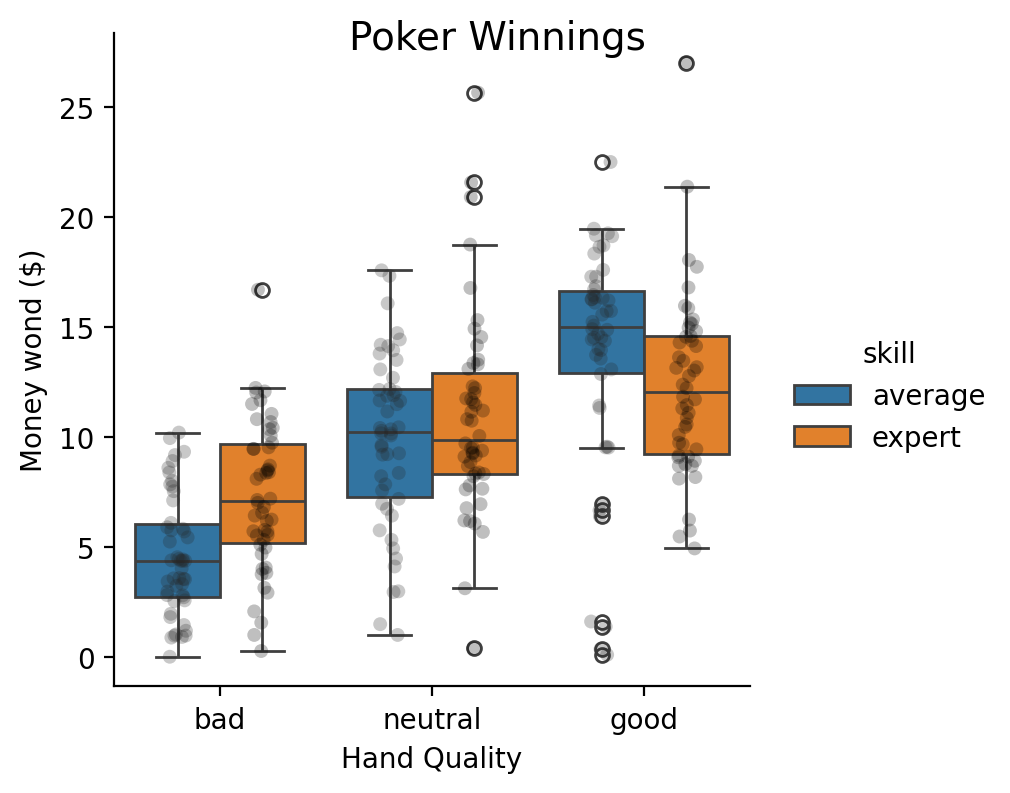

In [20]:
poker = load_dataset('poker')
grid = sns.catplot(
    x="hand",
    y="balance",
    kind="box",
    hue="skill",
    order=["bad", "neutral", "good"],
    hue_order=['average', 'expert'],
    aspect=1,
    height=4,
    data=poker.to_pandas(),
)
grid.map_dataframe(
    sns.stripplot,
    "hand",
    "balance",
    hue='skill',
    palette='dark:black',
    dodge=True,
    alpha=0.25,
    order=["bad", "neutral", "good"],
    hue_order=['average', 'expert'],
).set_axis_labels("Hand Quality", "Money wond ($)").figure.suptitle("Poker Winnings", x=.5, fontsize=14);

Let's say we wanted estimate a 2x3 factorial ANOVA. Like before we can use `.set_factors()` and then call `.anova()`. Specifying the factor levels isn't necessary (alphabetic by default), but makes it easier to explore the marginal estimates later.

In [37]:
poker = load_dataset('poker')

model = lm('balance ~ hand * skill', data=poker)

# Set factors
model.set_factors({'hand': ['bad', 'neutral','good'], 'skill':['average', 'expert']})

# Calculate ANOVA
model.anova(summary=True)

GT(_tbl_data=shape: (3, 6)
┌────────────┬─────┬───────┬─────────┬─────────┬───────┐
│ model term ┆ df1 ┆ df2   ┆ F_ratio ┆ p_value ┆ stars │
│ ---        ┆ --- ┆ ---   ┆ ---     ┆ ---     ┆ ---   │
│ str        ┆ f64 ┆ f64   ┆ f64     ┆ str     ┆ str   │
╞════════════╪═════╪═══════╪═════════╪═════════╪═══════╡
│ hand       ┆ 2.0 ┆ 294.0 ┆ 79.169  ┆ <.001   ┆ ***   │
│ skill      ┆ 1.0 ┆ 294.0 ┆ 2.434   ┆ 0.1198  ┆       │
│ hand:skill ┆ 2.0 ┆ 294.0 ┆ 7.083   ┆ <.001   ┆ ***   │
└────────────┴─────┴───────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x337844aa0>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x329061550>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x337847e00>, _formats=[<great_tables._gt_data.FormatInfo object at 0x328e570e0>, <great_tables._gt_data.FormatInfo object at 0x30bb43d70>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom

## More Marginal Effects Estimation
### Main effect of skill

Like before, we can unpack the F-test results using comparison between marginal means.  
The F-test result tells are there's no main-effect of skill, which we can verify by calculating the difference or *contrast* between each level of `skill` while averaging over levels of `hand`.  

Notice the p-value is the same and that $F=t^2$

In [38]:
skill_contrast = [1, -1]
model.emmeans('skill', contrasts={'avg_vs_expert': skill_contrast})

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""avg_vs_expert""",-0.724333,0.464243,294.0,-1.637994,0.189328,-1.560246,0.119778


We can verify the estimate matches what would have gotten had we calculated the ANOVA cell means ourselves:

In [39]:
average = model.data.filter(col('skill') == 'average').select('balance')
expert = model.data.filter(col('skill') == 'expert').select('balance')
average.mean() - expert.mean()

balance
f64
-0.724333


### Main effect of hand

The F-test for `hand` indicates a main effect but it doesn't tell us why.  
In the figure above, it looks like there's an increasing *linear trend* as we go from bad -> neutral -> good.  

Let's test that, while averaging over levels of `skill`

In [40]:
# Specified in the order of the factor levels, which we set above
hand_contrast = [-1, 0, 1]
model.emmeans('hand', contrasts={'linear_trend':hand_contrast})

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""linear_trend""",7.0849,0.568579,294.0,5.965899,8.203901,12.460706,6.6673e-29


We can again verify this estimate matches what we would have gotten through manual calculation:

In [41]:
bad = model.data.filter(col("hand") == "bad").select("balance").mean().item()
neutral = model.data.filter(col("hand") == "neutral").select("balance").mean().item()
good = model.data.filter(col("hand") == "good").select("balance").mean().item()

np.dot([bad, neutral, good], hand_contrast)

np.float64(7.084900000000006)

### Moderated by skill

Both the printed message from the previous contrast, as well as the F-test on the interaction tells us that this trend is going to vary depending upon which level of `skill` we look at.  
We can use `by` to subset out contrast for each level of `skill` to see how they differ

In [42]:
model.emmeans("hand", by="skill", contrasts={"linear_trend": hand_contrast})

contrast,skill,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
cat,cat,f64,f64,f64,f64,f64,f64,f64
"""linear_trend""","""average""",9.211,0.804093,294.0,7.628493,10.793507,11.455148,2.2922e-25
"""linear_trend""","""expert""",4.9588,0.804093,294.0,3.376293,6.541307,6.166951,2.2960e-9


It does look like the trend is steeper for *average* players vs *expert* players. Let's test that specific interaction by using `interaction` which allow us to declare a comparison for the `by="skill"` variable, in the same way that `contrasts` lets us decare a comparison for the `"hand"` variable

In [43]:
skill_contrast = [1, -1]

model.emmeans(
    "hand",
    by="skill",
    contrasts={"linear_trend": hand_contrast},
    interaction={"avg_vs_expert": skill_contrast},
)


contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""avg_vs_expert""",4.2522,1.137159,294.0,2.014197,6.490203,3.73932,0.000222


Since `skill` only has 2 levels, we could have used pairwise instead:

In [44]:
model.emmeans(
    "hand",
    by="skill",
    contrasts={"linear_trend": hand_contrast},
    interaction="pairwise",
)


contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""linear_trend average - linear_…",4.2522,1.137159,294.0,2.014197,6.490203,3.73932,0.000222


This is a little more work to calculate manually but matches our estimate:

In [45]:
bad_a = (
    model.data.filter(col("hand") == "bad", col("skill") == "average")
    .select("balance")
    .mean()
    .item()
)
neutral_a = (
    model.data.filter(col("hand") == "neutral", col("skill") == "average")
    .select("balance")
    .mean()
    .item()
)
good_a = (
    model.data.filter(col("hand") == "good", col("skill") == "average")
    .select("balance")
    .mean()
    .item()
)
bad_e = (
    model.data.filter(col("hand") == "bad", col("skill") == "expert")
    .select("balance")
    .mean()
    .item()
)
neutral_e = (
    model.data.filter(col("hand") == "neutral", col("skill") == "expert")
    .select("balance")
    .mean()
    .item()
)
good_e = (
    model.data.filter(col("hand") == "good", col("skill") == "expert")
    .select("balance")
    .mean()
    .item()
)

In [46]:
# Toggle code above to see calculations
np.dot([bad_a, neutral_a, good_a], hand_contrast) - np.dot(
    [bad_e, neutral_e, good_e], hand_contrast
)

np.float64(4.252199999999995)

### Comparison to re-parameterizing model

Alternatively, we can parameterize our regression model such that our coefficients reflect the comparisons we want, so called "planned comparisons". Rather than use `.anova()`, we'll now want to use `.fit()` and inspect the $k-1$ parameters for each $k$ level categorical predictor.


Let's change the default treatment-coding to the comparisons we care about:

In [48]:
# Reuse from before
# linear contrast across levels of hand 
# average - expert for skill
model.set_contrasts({'hand': hand_contrast, 'skill': skill_contrast})
model.show_contrasts()

{'hand': array([-1,  0,  1]), 'skill': array([ 1, -1])}


Now the estimates capture what we care about.   
Since `hand` has 3 levels, we need 2 parameters to fully capture it
- *hand1* = linear contrast (bad < neutral < good) averaged over skill 
- *hand2* = automatically computed quadratic contrast averaged over skill

Since `skill` had 2 levels, we just need 1 parameter to capture it
- *skill1* = average - expert difference averaged over hand

The first interaction parameter reflect linear trend difference we calculated above:
- *hand1:skill1* = linear contrast average skill - linear contrast expert skill
- *hand2:skill1* = automatically computed quadratic contrast average skill - quadratic contrast expert skill

In [49]:
model.fit(summary=True)

GT(_tbl_data=shape: (6, 9)
┌──────────────┬───────────┬───────────┬───────────┬───┬───────────┬─────┬─────────┬───────┐
│ term         ┆ estimate  ┆ std_error ┆ conf_low  ┆ … ┆ t_stat    ┆ df  ┆ p_value ┆ stars │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ --- ┆ ---     ┆ ---   │
│ str          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ i64 ┆ str     ┆ str   │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═════╪═════════╪═══════╡
│ (Intercept)  ┆ 9.7715    ┆ 0.232122  ┆ 9.31467   ┆ … ┆ 42.096481 ┆ 294 ┆ <.001   ┆ ***   │
│ hand1        ┆ 7.0849    ┆ 0.568579  ┆ 5.965899  ┆ … ┆ 12.460706 ┆ 294 ┆ <.001   ┆ ***   │
│ hand2        ┆ -0.704351 ┆ 0.402046  ┆ -1.495604 ┆ … ┆ -1.751915 ┆ 294 ┆ 0.08083 ┆ .     │
│ skill1       ┆ -0.724333 ┆ 0.464243  ┆ -1.637994 ┆ … ┆ -1.560246 ┆ 294 ┆ 0.1198  ┆       │
│ hand1:skill1 ┆ 4.2522    ┆ 1.137159  ┆ 2.014197  ┆ … ┆ 3.73932   ┆ 294 ┆ <.001   ┆ ***   │
│ hand2:skill1 ┆ 0.34448   ┆ 0.804093  ┆ -1.238027 ┆ … ┆ 0.428408  ┆ 294 ┆ 0.6687  ┆       │
└──────────────┴───────────┴───────────┴───────────┴───┴───────────┴─────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x337846bd0>, _boxhead=Boxhead([ColInfo(var='term', type=<ColInfoTypeEnum.stub: 2>, column_label='term', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x33785a510>, _spanners=Spanners([]), _heading=Heading(title='Formula: lm(balance~hand*skill)', subtitle=Md(text='Number of observations: *300*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            R-squared: *0.3731*  \n            R-squared-adj: *0.3624*  \n            *F(5, 294) = 34.988, p = <.001*  \n            Log-likelihood: *-840*  \n            AIC: *1694* | BIC: *1720*  \n            Residual error: *4.02*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=Non

### All pairwise comparisons

Though not encouraged, we can also calculate the pairwise comparisons between every combination of `hand` and `skill`

In [50]:
model.emmeans(['hand', 'skill'], contrasts='pairwise', p_adjust='bonferroni')

contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""bad average - neutral average""",-5.2572,0.804093,294.0,-7.636816,-2.877584,-6.538053,4.1276e-9
"""bad average - good average""",-9.211,0.804093,294.0,-11.590616,-6.831384,-11.455148,3.4383e-24
"""bad average - bad expert""",-2.7098,0.804093,294.0,-5.089416,-0.330184,-3.37001,0.012781
"""bad average - neutral expert""",-6.2628,0.804093,294.0,-8.642416,-3.883184,-7.788655,1.7546e-12
"""bad average - good expert""",-7.6686,0.804093,294.0,-10.048216,-5.288984,-9.536961,8.7939e-18
…,…,…,…,…,…,…,…
"""good average - neutral expert""",2.9482,0.804093,294.0,0.568584,5.327816,3.666493,0.004376
"""good average - good expert""",1.5424,0.804093,294.0,-0.837216,3.922016,1.918187,0.840836
"""bad expert - neutral expert""",-3.553,0.804093,294.0,-5.932616,-1.173384,-4.418645,0.00021


## With continuous predictor(s) (e.g. ANCOVA/moderation)

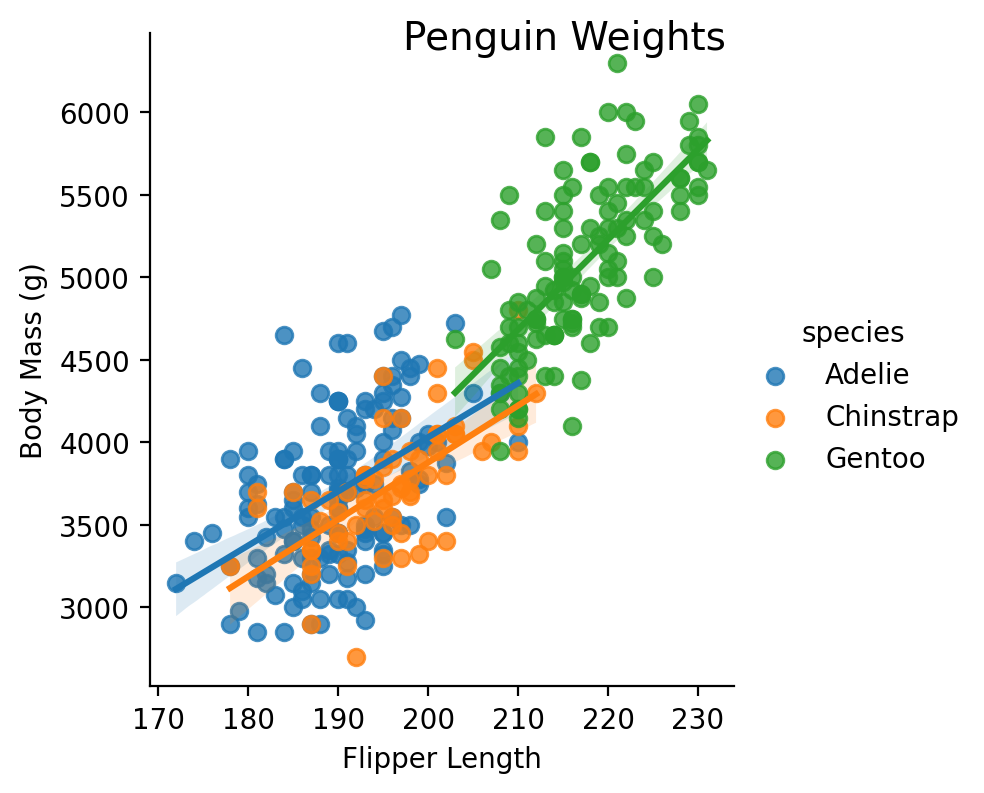

In [6]:
grid = sns.lmplot(
    x="flipper_length_mm",
    y="body_mass_g",
    hue="species",
    hue_order=["Adelie", "Chinstrap", "Gentoo"],
    aspect=1,
    height=4,
    data=penguins.to_pandas(),
)
grid.set_axis_labels("Flipper Length", "Body Mass (g)").figure.suptitle("Penguin Weights", x=.6, fontsize=14);

Models with mixed continuous and factor models work exactly the same.  
Here we explore whether there's an interaction between species and flipper length, i.e. whether a penguin's species changes the relationship between flipper length and body mass.

In [51]:
model = lm('body_mass_g ~ species * flipper_length_mm', data=penguins)

# Categorical
model.set_factors('species')
model.set_contrasts({'species':'contr.sum'})

# Continuous
model.set_transforms({'flipper_length_mm': 'center'})

# Calculate ANOVA
model.anova(summary=True)

GT(_tbl_data=shape: (3, 6)
┌───────────────────────────┬─────┬───────┬─────────┬──────────┬───────┐
│ model term                ┆ df1 ┆ df2   ┆ F_ratio ┆ p_value  ┆ stars │
│ ---                       ┆ --- ┆ ---   ┆ ---     ┆ ---      ┆ ---   │
│ str                       ┆ f64 ┆ f64   ┆ f64     ┆ str      ┆ str   │
╞═══════════════════════════╪═════╪═══════╪═════════╪══════════╪═══════╡
│ species                   ┆ 2.0 ┆ 336.0 ┆ 3.934   ┆ 0.02047  ┆ *     │
│ flipper_length_mm         ┆ 1.0 ┆ 336.0 ┆ 168.292 ┆ <.001    ┆ ***   │
│ species:flipper_length_mm ┆ 2.0 ┆ 336.0 ┆ 5.532   ┆ 0.004327 ┆ **    │
└───────────────────────────┴─────┴───────┴─────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x335f65a90>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3378480e0>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x335f67770>, _formats=[<great_tables._gt_data.FormatInfo object at 0x3378482c0>, <great_tables._gt_data.FormatInfo object at 0x33785b560>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='

While we *could* try to understand these relationships just based on the estimated parameters, it's much easier to unpack them using marginal effects estimation

In [60]:
model.params

term,estimate
str,f64
"""(Intercept)""",4052.294709
"""species1""",8.254155
"""species2""",-143.169979
"""flipper_length_mm""",40.675862
"""species1:flipper_length_mm""",-7.844172
"""species2:flipper_length_mm""",-6.102468


## Even more Marginal Effects Estimation

$flipper\_length\_mm$ above is the slope of `flipper_length_mm` averaged over `species` since we used  *sum (deviation)* coding

In [53]:
model.emmeans('flipper_length_mm')

R messages: 
NOTE: Results may be misleading due to involvement in interactions



flipper_length_mm_trend,SE,df,lower_CL,upper_CL
f64,f64,f64,f64,f64
40.675862,3.135487,336.0,34.508204,46.84352


$species1$ is the first parameter of our *sum (deviation)* coding which represents factor levels as a differences from the *grand-mean*, when `flipper_length_mm` is held at its mean.

In [54]:
species_means = model.emmeans('species').select('emmean')
grand_mean = species_means.mean().item()
adelie_mean = species_means[0]
adelie_mean - grand_mean

R messages: 
NOTE: Results may be misleading due to involvement in interactions



emmean
f64
8.254155


$species2$ is the difference between the next factor level (Chinstrap) and the grand-mean

In [55]:
species_means[1] - grand_mean

emmean
f64
-143.169979


With marginal estimation we can also ask questions about our continuous predictor. For example, passing using `flipper_length_mm` as our first variable and `species` as our `by` variable we can see how the slope of $flipper length$ varies across $species$

In [61]:
model.emmeans('flipper_length_mm', by='species')

species,flipper_length_mm_trend,SE,df,lower_CL,upper_CL
cat,f64,f64,f64,f64,f64
"""Adelie""",32.83169,4.627184,336.0,21.727836,43.935543
"""Chinstrap""",34.573394,6.348364,336.0,19.339225,49.807563
"""Gentoo""",54.622502,5.173874,336.0,42.206757,67.038247


Like before, we can use the `contrasts` argument to specify a test across levels of our `by` variable, i.e. a test across the different *slopes* above.

Here we test whether the relationship between flipper_length and weight gets *stronger* across species: Adelie < Chinstrap < Gentoo, i.e. that the slope *increases*

In [62]:
model.emmeans("flipper_length_mm", by="species", contrasts={"linear": [-1, 0, 1]}, normalize=True)

contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""linear""",15.408431,4.908146,336.0,5.753865,25.062997,3.139359,0.001843


### Counter-factual estimates & comparisons

We can also calculate marginal means at arbitrary values of `flipper_length_mm` using the `at` keyword and passing in 1 or more values. Let's test a hypothetical question: how would species differ in weight if we were to observe a very short `flipper_length_mm` of 150mm?

We never actually *observe* this value of `flipper_length_mm` but can we can use the model to generate a *counter-factual* comparisons to get an answer:

In [63]:
model.emmeans('species', at={'flipper_length_mm': 150}, contrasts='pairwise')

R messages: 
NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,lower_CL,upper_CL,t_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""Adelie - Chinstrap""",240.103356,348.902095,336.0,-597.157041,1077.363752,0.688168,0.868765
"""Adelie - Gentoo""",982.82199,396.284903,336.0,31.857066,1933.786915,2.480089,0.040319
"""Chinstrap - Gentoo""",742.718635,456.726766,336.0,-353.288637,1838.725907,1.626177,0.282721


For even more control we can use `.empredict()` to generate predictions for *arbitrary* combinations of our predictors. This allows us to ask very specific questions like:  

How much would an Adelie penguin weigh if it had a flipper length of 210mm?

`.empredict()` (and `.emmeans()`) will automatically handle transformations from `.set_transforms()` and return values of the predictor on the transformed scale along with predictions and uncertainty

In [64]:
model.empredict({'flipper_length_mm': 210, 'species': 'Adelie'})

species,flipper_length_mm,prediction,SE,df,lower_CL,upper_CL
cat,f64,f64,f64,f64,f64,f64
"""Adelie""",9.084795,4358.818046,97.537889,336.0,4166.956202,4550.67989


Using the special `'data'` value allows us to easily reference all the *observed* values for a predictor. For example, we can generate unit-level predictions using all observed flipper lengths only for Chinstrap and Gentoo penguins

In [66]:
model.empredict({'flipper_length_mm': 'data', 'species': ['Chinstrap', 'Gentoo']}).head()

species,flipper_length_mm,prediction,SE,df,lower_CL,upper_CL
cat,f64,f64,f64,f64,f64,f64
"""Chinstrap""",-19.915205,3220.588515,104.285847,336.0,3015.453103,3425.723926
"""Gentoo""",-19.915205,3099.392229,190.185526,336.0,2725.287906,3473.496551
"""Chinstrap""",-14.915205,3393.455484,76.869652,336.0,3242.249081,3544.661886
"""Gentoo""",-14.915205,3372.504738,164.781292,336.0,3048.371798,3696.637678
"""Chinstrap""",-5.915205,3704.616029,45.244783,336.0,3615.617307,3793.61475
